In [1]:
import numpy as np
import random
import copy
up_space = 1
low_space = -1
class NeuralNetwork:
    def __init__(self, layer_sizes, weights=None):
        self.layer_sizes = layer_sizes
        if weights is None:
            # Initialize random weights if none are provided
            self.weights = [np.random.uniform(low_space, up_space, size=(y, x)) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        else:
            # Use provided weights
            self.weights = weights

    def forward_pass(self, input_data):
        activations = input_data
        for weights in self.weights:
            # Matrix multiplication between last layer outputs and weights + sigmoid activation
            activations = self.tanh(np.dot(activations, weights.T))
        return activations

    @staticmethod
    def sigmoid(x):
        """
        Sigmoid activation function.
        """
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def tanh(x):
        """
        Tanh activation function
        """
        return np.tanh(x)

In [2]:
def mutx(o_weights, mutation_rate,):
    weights = copy.deepcopy(o_weights)
    if np.random.rand() < mutation_rate:
        # Compute the difference 'd' as described
        d = up_space - low_space
        # Generate random changes within the range defined by 'd'
        random_changes = np.random.rand(*weights.shape) * d + low_space
        # Assign new values to the weights
        weights = random_changes
    # Clamp the weights to ensure they remain within the specified bounds
    np.clip(weights, low_space, up_space, out=weights)
    return weights

In [3]:
def muta(o_weights, mutation_rate, fraction=10):    
    upper_amplitude = up_space / fraction
    lower_amplitude = low_space / fraction
    weights = copy.deepcopy(o_weights)
    # Mutation process
    for i in range(len(weights)):
        if np.random.rand() < mutation_rate:
            # Choose amplitude from either upper or lower bound randomly
            amplitude = random.choice([upper_amplitude, lower_amplitude])
            # Generate a random value between -1 and 1, scale it by the chosen amplitude
            mutation = (2 * np.random.rand() - 1) * amplitude
            weights[i] += mutation
            # Clamp the mutated weights to stay within specified bounds
            weights[i] = np.clip(weights[i], low_space, up_space)
    return weights

In [4]:
def crossover(population):
    new_population = []
    # Ensure we pick pairs, so we need an even number of individuals
    num_pairs = len(population) // 2

    for _ in range(num_pairs):
        # Randomly select two parents without replacement
        parent1, parent2 = np.random.choice(population, 2, replace=False)

        # Perform crossover to produce two children
        for _ in range(2):  # Produce two children
            child_weights = []
            for weights1, weights2 in zip(parent1.weights, parent2.weights):
                # Create a mask for crossover
                mask = np.random.rand(*weights1.shape) > 0.5
                # Apply mask to create a new child's weights
                child_weight = np.where(mask, weights1, weights2)
                child_weights.append(child_weight)

            # Create a new NeuralNetwork object for the child
            child = NeuralNetwork(parent1.layer_sizes, weights=child_weights)
            new_population.append(child)

            # Make sure we do not exceed the original population size
            if len(new_population) >= len(population):
                return new_population

    # In case the original population size is odd and we have room for one more
    if len(new_population) < len(population):
        new_population.append(copy.deepcopy(np.random.choice(population)))

    return new_population

In [5]:
def select_best(population, fitness_scores, selection_counts):
    new_population = copy.deepcopy(population)
    sorted_indices = np.argsort(fitness_scores)[::-1]
    result_population = []
    for count, index in zip(selection_counts, sorted_indices):
        # Extend the result population with 'count' copies of the 'index'-th best individual
        result_population.extend([new_population[index]] * count)
    return result_population

In [6]:
def select_rul(population, fitness_scores, selection_size):
    new_population = copy.deepcopy(population)
    total_fitness = sum(fitness_scores)  # Sum of all fitness scores
    selection_probs = [score / total_fitness for score in fitness_scores]  # Probability for each individual
    
    selected = random.choices(
        population=new_population, 
        weights=selection_probs, 
        k=selection_size
    )
    
    return selected

In [7]:
def select_rand(population, selection_size):
    new_population = copy.deepcopy(population)
    selected = random.sample(new_population, selection_size)
    return selected

In [8]:
import pickle
import numpy as np
import neat
import datetime
import os
import math

from comunication_channel import AgentLogChannel

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

In [9]:
def map_agent_ids(decision_steps):
    """
    Map agent ids between NEAT and UNITY.

    Args:
        decision_steps: An iterable containing decision steps.

    Returns:
        A tuple of two dictionaries: (unity_to_neat_map, neat_to_unity_map)
    """
    unity_to_neat_map = {}
    neat_to_unity_map = {}
    id_count = 0
    for step in decision_steps:
        unity_to_neat_map[step] = id_count
        neat_to_unity_map[id_count] = step
        id_count += 1
    return unity_to_neat_map, neat_to_unity_map

In [10]:
engine_config_channel = EngineConfigurationChannel()
engine_config_channel.set_configuration_parameters(time_scale=10)
agent_count_channel = AgentLogChannel()

env_path = "../Builds/train-env/autonomous-drone.exe"
save_nn_destination = 'result/best.pkl'

env = UnityEnvironment(file_name=None, worker_id=0, no_graphics=True, side_channels=[engine_config_channel, agent_count_channel])
env.reset()

In [11]:
def set_agents_and_double_reset(num_agents: int):
    agent_count_channel.send_int(data=num_agents) 
    env.reset()
    env.reset()

In [12]:
out_mult = 1

behavior_specs = env.behavior_specs
print(f"Behaviour specs {behavior_specs}")
behavior_name = list(behavior_specs)[0]
spec = env.behavior_specs[behavior_name]

print(f"Name of the behavior : {behavior_name}")
print("Number of observations : ", len(spec.observation_specs)) # vector if 1

# Is the Action continuous or multi-discrete ?
if spec.action_spec.continuous_size > 0:
  print(f"There are {spec.action_spec.continuous_size} continuous actions")
if spec.action_spec.is_discrete():
  print(f"There are {spec.action_spec.discrete_size} discrete actions")

Behaviour specs <mlagents_envs.base_env.BehaviorMapping object at 0x000002050B49D900>
Name of the behavior : DroneControl?team=0
Number of observations :  1
There are 4 continuous actions


In [13]:
import time
def eval_genomes(population, num_runs: int):
    episode_rewards = [0] * len(population)
    for _ in range(num_runs):
        env.reset()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        agent_count = len(decision_steps.agent_id)
        unity_to_neat_map, neat_to_unity_map = map_agent_ids(decision_steps)
        done = False  # Vectorized initialization
        removed_agents = []

        while not done:
            for agent in decision_steps:
                if unity_to_neat_map[agent] not in removed_agents:
                    nn_input =  np.asarray(decision_steps[agent].obs[:])
                    #print(f"NN INPUT: {nn_input}, agent: {agent}")
                    actions = population[unity_to_neat_map[agent]].forward_pass(nn_input)
                    continous_actions = np.asarray(actions)
                    continous_actions = np.clip(continous_actions, -1, 1)
                    #print(f"Actions {agent} {continous_actions}")
                    action_tuple = ActionTuple(discrete=None, continuous=continous_actions)
                    env.set_action_for_agent(behavior_name=behavior_name, 
                                            agent_id=agent, 
                                            action=action_tuple)
            env.step()
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            for agent in range(agent_count):
                if agent not in removed_agents:
                    local_agent = neat_to_unity_map[agent]
                    if local_agent in terminal_steps:
                        episode_rewards[agent] += terminal_steps[local_agent].reward
                        removed_agents.append(agent)
                        #print(f"Finished: {agent}")
                    elif local_agent in decision_steps:
                        episode_rewards[agent] += decision_steps[local_agent].reward
            if len(removed_agents) >= agent_count:
                done = True
    return np.array(episode_rewards)/num_runs

In [14]:
def adaptive_mutation_rate(generation, max_generations):
    return max(0.1, 1 - (generation / max_generations))

In [15]:
from tqdm import tqdm

def run_genetic_algorithm(generations=50, population_size=50, top_k=5):
    # Initialize population
    population = [NeuralNetwork([16, 10, 10, 4]) for _ in range(population_size)]
    best_fitness_history = []  # To store the best fitness in each generation

    pbar = tqdm(range(generations), desc='Initializing', leave=True)
    
    for generation in pbar:
        # Evaluate fitness of the population
        fitness_scores = eval_genomes(population, 1)
        best_fitness = max(fitness_scores)
        best_fitness_history.append(best_fitness)  # Save the best fitness of this generation
        
        # Update tqdm description with current best fitness
        pbar.set_description(f"Gen {generation+1} | Best Fitness: {best_fitness:.2f}")
        pbar.refresh()

        # Select via different methods
        selected_best = select_best(population, fitness_scores, [2, 1])
        selected_best2 = select_best(population, fitness_scores, [1, 1])
        selected_rand = select_rand(population, population_size - top_k * 2)
        selected_rul = select_rul(population, fitness_scores, top_k)
        
        # Generate new population
        new_population = []
        new_population.extend(selected_best)
        for individual in selected_best2:
            individual.weights = [muta(w, 0.2) for w in individual.weights]
            new_population.append(individual)
        for individual in selected_rand:
            individual.weights = [muta(w, 0.2) for w in individual.weights]
            new_population.append(individual)
            
        selected_rul = crossover(selected_rul)
        
        for individual in selected_rul:
            # here do crossov
            individual.weights = [mutx(w, 0.2) for w in individual.weights]
            new_population.append(individual)
        
        population = new_population
    return population, best_fitness_history

In [16]:
population_size = 50
set_agents_and_double_reset(population_size)

population, best_fitness_history = run_genetic_algorithm(generations=2000, population_size=population_size, top_k=5)

Gen 473 | Best Fitness: 1.72:  24%|██▎       | 473/2000 [12:14<43:50,  1.72s/it]  

In [ ]:
env.close()

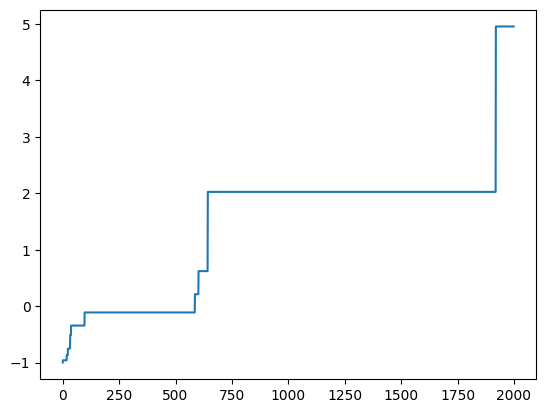

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_fitness_history)

In [ ]:
selected_best[0]

NameError: name 'selected_best' is not defined

In [ ]:
datte = datetime.datetime.now().strftime("%d-%m-%Y--%H_%M")

# Save best genome
with open(f'logs/ne/{datte}/best.pkl', 'wb') as f:
    pickle.dump(ne_best, f)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/ne/13-04-2024--19_44/best.pkl'